In [7]:
#!rm -r /root/.cache* /root/.config* /root/Desktop*

In [1]:
import argparse
import os

import numpy
import numpy as np
from omegaconf import DictConfig

import habitat
from habitat.config.default_structured_configs import register_hydra_plugin
from habitat_baselines.config.default import get_config
from habitat.config.default_structured_configs import (HeadingSensorConfig,TopDownMapMeasurementConfig)
import sys
import pandas as pd
import matplotlib.pyplot as plt
#from utils import FrameSkip, FrameStack, draw_top_down_map, plot_colortable, rand_cmap
import numba
import random
from moviepy.editor import ImageSequenceClip
import cv2
from utils import FrameSkip, FrameStack, draw_top_down_map, plot_colortable, rand_cmap
import torch

#!ln -s /data /root/HABITAT_23_RL/data
#!ln -s /data/scene_datasets/hm3d /data/scene_datasets/hm3d_v0.2

pybullet build time: Oct 28 2022 16:15:14


ModuleNotFoundError: No module named 'utils'

In [3]:
#!pip install git+https://github.com/openai/CLIP.git

In [4]:
import io
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

# Config load

In [5]:
from hydra.core.config_search_path import ConfigSearchPath
from hydra.plugins.search_path_plugin import SearchPathPlugin


class HabitatChallengeConfigPlugin(SearchPathPlugin):
    def manipulate_search_path(self, search_path: ConfigSearchPath) -> None:
        search_path.append(
            provider="habitat_challenge",
            path="file:/configs",
        )

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--input-type",
    default="rgbd",
    choices=["blind", "rgb", "depth", "rgbd"],
)
parser.add_argument(
    "--evaluation", type=str, required=True, choices=["local", "remote"]
)
parser.add_argument("--model-path", default="", type=str)
parser.add_argument(
    "--task", required=True, type=str, choices=["objectnav", "imagenav"]
)
parser.add_argument("--task-config", type=str, required=True)
parser.add_argument(
    "--action_space",
    type=str,
    default="velocity_controller",
    choices=[
        "velocity_controller",
        "waypoint_controller",
        "discrete_waypoint_controller",
    ],
    help="Action space to use for the agent",
)
parser.add_argument(
    "overrides",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)


benchmark_config_path =  "/root/configs/benchmark/nav/objectnav/objectnav_v2_hm3d_stretch_challenge.yaml"
args = parser.parse_args('--evaluation local --model-path objectnav_baseline_habitat_navigation_challenge_2023.pth --input-type rgbd --task objectnav --action_space discrete_waypoint_controller --task-config /root/configs/ddppo_objectnav_v2_hm3d_stretch.yaml'.split())

In [7]:
register_hydra_plugin(HabitatChallengeConfigPlugin)
overrides = args.overrides + [
        'habitat_baselines.rl.policy.action_distribution_type=categorical', 
        'habitat_baselines.load_resume_state_config=True',
        "benchmark/nav/" + args.task + "=" + os.path.basename(benchmark_config_path),
        "habitat/task/actions=" + args.action_space,
        "habitat.dataset.split=val",
        "habitat.dataset.data_path=/data/datasets/objectnav/hm3d/v2/val/val.json.gz",
        "+pth_gpu_id=0",
        "+input_type=" + args.input_type,
        "+model_path=" + args.model_path,
        "+random_seed=7",
    ]
os.environ["CHALLENGE_CONFIG_FILE"] = "/root/configs/benchmark/nav/objectnav/objectnav_v2_hm3d_stretch_challenge.yaml"
config = get_config(
        args.task_config,
        overrides,
    )
#"""
with habitat.config.read_write(config):    
    config.habitat.task.lab_sensors.update(
        {"heading_sensor": HeadingSensorConfig()})
with habitat.config.read_write(config):
    config.habitat.task.measurements.update(
        {"top_down_map": TopDownMapMeasurementConfig()})
#"""        

NameError: name 'register_hydra_plugin' is not defined

# Init Env

In [1]:
from habitat import make_dataset
_dataset = make_dataset(id_dataset=config.habitat.dataset.type, config=config.habitat.dataset)

NameError: name 'config' is not defined

In [ ]:
from env_orb_23 import Env
one_env = Env(config=config,dataset=_dataset)

[29.535595]


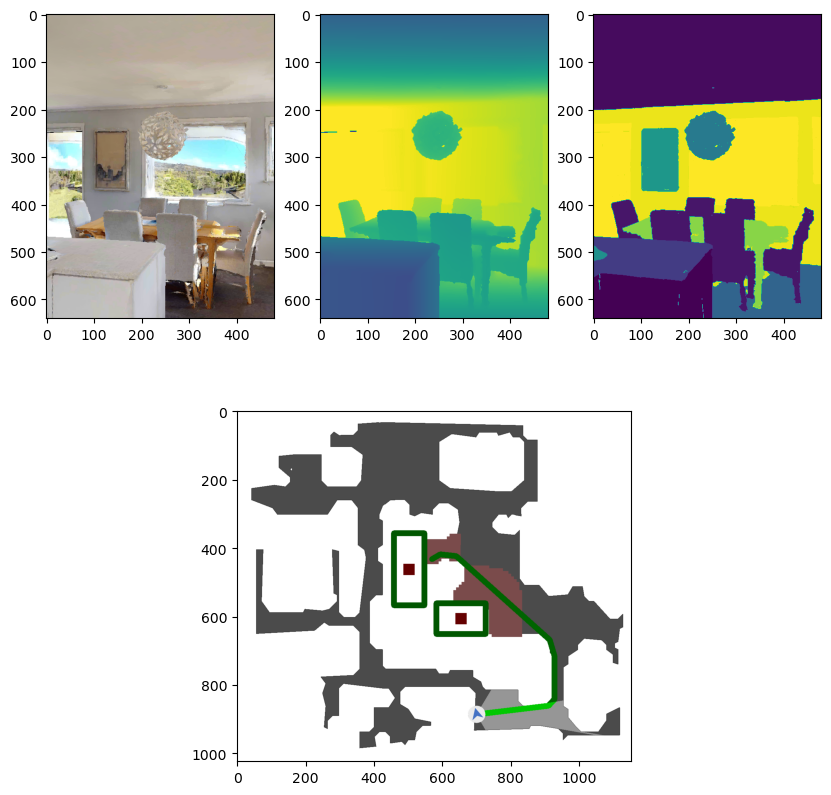

In [20]:
obs = one_env.reset(); idd = 0
#obs, reward, done, info = one_env.step(action=2)
obs, reward, done, info = one_env.step(action=2)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(2,3,1)
ax1 = f.add_subplot(2,3,2)
ax2 = f.add_subplot(2,3,3)
ax3 = f.add_subplot(2,1,2)
ax.imshow(obs['rgb'])
ax1.imshow(obs['depth'][:,:,0])
ax2.imshow(one_env.sem_to_model[:,:,0])
top_down_map = draw_top_down_map(info,obs['heading'][0],obs['rgb'][0].shape[0])
ax3.imshow(top_down_map)
print(np.rad2deg(obs['compass']))

In [20]:
observations = one_env.task.step(action={'action':2}, episode=one_env._current_episode)
observations = one_env.task.step(action={'action':3}, episode=one_env._current_episode)

[11] [ 0  6  7  8  9 12 17 22 23 30 38 39]


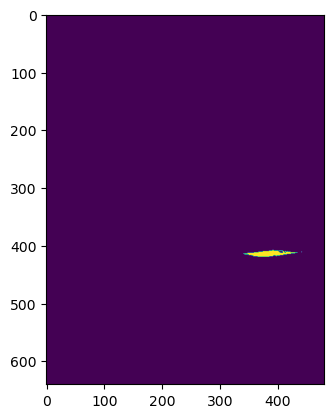

In [23]:
plt.imshow(one_env.sem_to_model[:,:,0]==30)
print(one_env.objectgoal,np.unique(one_env.sem_to_model))

# Exploration RL

In [21]:
from habitat.config import DictConfig as Config
from hab_base_utils_common import batch_obs, batch_obs1
from torchvision import transforms

p240 = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((320,240)),
                                transforms.ToTensor()])

In [22]:
from gym.spaces import Dict
from gym.spaces import Box, Dict, Discrete
from EXPLORE_policy import ResNetPolicy

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__  
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_space1 = dotdict()
obs_space1.spaces = {}
obs_space1.spaces['rgb'] = Box(low=0, high=0, shape=(3,320,240), dtype=np.uint8)
obs_space1.spaces['depth'] = Box(low=0, high=0, shape=(1,320,240), dtype=np.uint8)
obs_space1.spaces['pointgoal_with_gps_compass'] = Box(low=0, high=0, shape=(2,), dtype=np.uint8)
obs_space1.spaces['task_id'] = Box(low=0, high=1, shape=(1,), dtype=np.uint8)
act_space = dotdict()
act_space.n = 4
act_space.shape = [1] 
actor_critic_explore = ResNetPolicy(
            observation_space=obs_space1,
            action_space=act_space,
            hidden_size=512,
            resnet_baseplanes=64,
            rnn_type='LSTM',
            num_recurrent_layers=1,
            backbone='resnet18',
        )
pretrained_state = torch.load('/root/weights/explore_model_32.pth', map_location="cpu")
actor_critic_explore.load_state_dict(pretrained_state)
actor_critic_explore.to(device)
actor_critic_explore.eval()

(10, 8)
2048 32
LOADED CLIP


ResNetPolicy(
  (ac): ScriptableAC(
    (net): ResNetNet(
      (prev_action_embedding): Embedding(5, 32)
      (tgt_embeding): Linear(in_features=3, out_features=32, bias=True)
      (gps_embeding): Sequential()
      (taskid_embeding): Linear(in_features=1, out_features=32, bias=True)
      (visual_encoder): ResNetEncoder(
        (backbone): ResNet(
          (stem): Sequential(
            (0): SpaceToDepth()
            (1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): GroupNorm(32, 64, eps=1e-05, affine=True)
            (3): ReLU(inplace=True)
          )
          (layers): ModuleList(
            (0): Sequential(
              (0): BasicBlock(
                (convs): Sequential(
                  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
                  (2): ReLU(inplace=True)
                  (3): Conv2d(64, 64, kernel_size=(3, 3), st

In [23]:
torch.__version__

'1.9.1+cu111'

plant [-8.61462e-06]


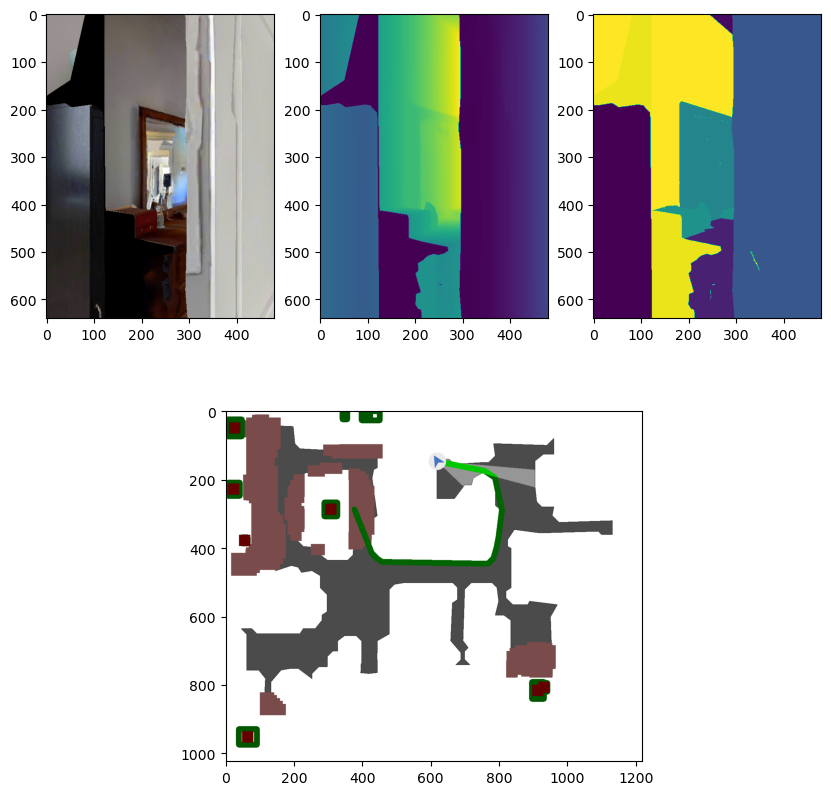

In [26]:
obs = one_env.reset(); idd = 0; done = False
obs, reward, done, info = one_env.step(action=3)
obs, reward, done, info = one_env.step(action=2)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(2,3,1)
ax1 = f.add_subplot(2,3,2)
ax2 = f.add_subplot(2,3,3)
ax3 = f.add_subplot(2,1,2)
ax.imshow(obs['rgb'])
ax1.imshow(obs['depth'][:,:,0])
ax2.imshow(one_env.sem_to_model[:,:,0])
top_down_map = draw_top_down_map(info,obs['heading'][0],obs['rgb'][0].shape[0])
ax3.imshow(top_down_map)
print(one_env.objectgoal_name,np.rad2deg(obs['compass']))

In [ ]:
test_recurrent_hidden_states_gr = torch.zeros(1, 2, 512, device=device)
not_done_masks = torch.zeros(1, 1, dtype=torch.bool, device=device)
prev_actions = torch.zeros(1, 1, dtype=torch.long, device=device)
imgs = []; idd = 0
while not done:

    rgb_trans = (p240(obs['rgb']).permute(1,2,0)*255).int()
    depth_trans = p240(obs['depth']).permute(1,2,0)

    batch = batch_obs([{'task_id':np.ones((1,))*1,
                                    'pointgoal_with_gps_compass':np.zeros((2,)),
                                    'depth':depth_trans,
                                    'rgb':rgb_trans}], device=device)

    with torch.no_grad():
        ac_dop1, action, test_recurrent_hidden_states_gr = actor_critic_explore.act(
            batch,
            test_recurrent_hidden_states_gr,
            prev_actions,
            not_done_masks.bool())
        action = action['actions']
        not_done_masks.fill_(1.0)
        prev_actions.copy_(action) 
        action = action.item()

    obs,reward,done,info = one_env.step(action); idd+=1
    
    
    print(idd,'\t',action)
    
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(2,3,1)
    ax1 = f.add_subplot(2,3,2)
    ax2 = f.add_subplot(2,3,3)
    ax3 = f.add_subplot(2,1,2)
    ax.imshow(rgb_trans)
    ax1.imshow(depth_trans[:,:,0])
    ax2.imshow(one_env.sem_to_model[:,:,0])
    top_down_map = draw_top_down_map(info,obs['heading'][0],obs['rgb'][0].shape[0])
    ax3.imshow(top_down_map)
    plot_img_np = get_img_from_fig(f)
    plt.close()
    
    imgs.append(plot_img_np)   
    
    if idd>=100:
        break

1 	 2
2 	 2
3 	 2
4 	 2
5 	 2
6 	 2
7 	 2
8 	 2
9 	 2
10 	 2
11 	 2
12 	 1
13 	 2
14 	 2
15 	 2
16 	 2
17 	 1
18 	 2
19 	 1
20 	 3
21 	 3
22 	 1
23 	 3
24 	 3
25 	 3
26 	 3
27 	 3
28 	 3
29 	 3
30 	 3
31 	 1
32 	 3
33 	 1
34 	 3
35 	 3
36 	 1
37 	 1
38 	 3
39 	 1
40 	 1
41 	 1
42 	 3
43 	 1
44 	 1
45 	 3
46 	 3
47 	 3
48 	 3
49 	 3
50 	 3
51 	 3
52 	 3
53 	 1
54 	 1
55 	 3
56 	 3
57 	 1
58 	 1
59 	 3
60 	 3
61 	 1
62 	 3
63 	 3
64 	 3
65 	 3
66 	 1
67 	 1
68 	 1
69 	 3
70 	 3
71 	 3
72 	 1
73 	 1
74 	 1
75 	 1
76 	 3
77 	 3
78 	 1
79 	 3
80 	 1
81 	 3
82 	 3
83 	 1
84 	 3
85 	 1
86 	 3
87 	 1
88 	 1
89 	 1
90 	 1
91 	 2
92 	 2
93 	 3
94 	 3
95 	 1
96 	 3
97 	 3
98 	 3
99 	 1
100 	 1
101 	 2
102 	 1
103 	 1
104 	 2
105 	 1
106 	 3
107 	 1
108 	 3
109 	 3
110 	 3
111 	 3
112 	 3
113 	 1
114 	 3
115 	 3
116 	 3
117 	 3
118 	 3
119 	 1
120 	 3
121 	 3
122 	 3
123 	 3
124 	 3
125 	 1
126 	 1
127 	 2
128 	 1
129 	 2
130 	 1
131 	 2
132 	 1
133 	 2
134 	 1
135 	 2
136 	 2
137 	 1
138 	 2
139 

In [ ]:
imgs = [{'plts':i} for i in imgs]

In [ ]:
from habitat_sim.utils import viz_utils as vut
vut.make_video(
            imgs,
            "plts",
            "color",
            '/' + "sim_basics_3rd",
            open_vid=True,
            fps=10,
        )

In [10]:
import pickle

with open('example_traj.pickle', 'rb') as handle:
    import_pickle = pickle.load(handle)

In [11]:
btchs = import_pickle['btchs']
recrnts = import_pickle['recrnts']
prv_actns = import_pickle['prv_actns']
nt_dn_msks = import_pickle['nt_dn_msks']

ac_outs = import_pickle['ac_outs']
actns_out = import_pickle['actns_out']
recs_out = import_pickle['recs_out']

In [12]:
for i in range(len(btchs)):
    with torch.no_grad():
        ac_dop1, action, test_recurrent_hidden_states_gr = actor_critic_explore.act(
            btchs[i],
            recrnts[i],
            prv_actns[i],
            nt_dn_msks[i].bool())
    print(i,'\t',action['actions'].item(),action['action_log_probs'].item(),
          actns_out[i]['actions'].item(),actns_out[i]['action_log_probs'].item())
    
    
    

0 	 2 -0.0018362818518653512 2 -0.0018362818518653512
1 	 1 -0.00018857131362892687 1 -0.00018857131362892687
2 	 1 -0.0008326877141371369 1 -0.0008326877141371369
3 	 1 -0.0017751187551766634 1 -0.0017751187551766634
4 	 1 -0.002957139629870653 1 -0.002957139629870653
5 	 1 -0.0025521109346300364 1 -0.0025521109346300364
6 	 1 -0.00033301531220786273 1 -0.00033301531220786273
7 	 1 -2.8013790142722428e-05 1 -2.8013790142722428e-05
8 	 1 -1.5497195136049413e-06 1 -1.5497195136049413e-06
9 	 1 -1.8715683836489916e-05 1 -1.8715683836489916e-05
10 	 1 -0.0012837749673053622 1 -0.0012837749673053622
11 	 1 -0.02534843236207962 1 -0.02534843236207962
12 	 1 -0.11383179575204849 1 -0.11383084207773209
13 	 1 -0.07522352784872055 2 -2.6247811317443848
14 	 1 -4.529942543740617e-06 1 -4.529942543740617e-06
15 	 1 -0.01666118949651718 1 -0.01666107214987278
16 	 1 -0.8113677501678467 2 -1.3239655494689941
17 	 1 -4.1960789531003684e-05 1 -4.1960789531003684e-05
18 	 1 -0.01134009100496769 1 -0.

# GoalReacher RL

In [32]:
from gym.spaces import Dict
from gym.spaces import Box, Dict, Discrete
from GR_policy import PointNavResNetPolicy

from habitat.config import DictConfig as Config
from hab_base_utils_common import batch_obs, batch_obs1
from torchvision import transforms

p240 = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((320,240)),
                                transforms.ToTensor()])

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__  
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
obs_space2 = dotdict()
obs_space2.spaces = {}
obs_space2.spaces['rgb'] = Box(low=-1000, high=1000, shape=(240,320,3), dtype=np.float32)
obs_space2.spaces['depth'] = Box(low=-1000, high=1000, shape=(240,320,1), dtype=np.float32)
obs_space2.spaces['semantic'] = Box(low=-1000, high=1000, shape=(240,320,1), dtype=np.float32)
act_space2 = dotdict()
act_space2.n = 5
act_space2.shape = [1] 
actor_critic_gr = PointNavResNetPolicy(
    observation_space = obs_space2,
    action_space = act_space2,
    hidden_size = 512,
    rnn_type = 'GRU',
    num_recurrent_layers = 1,
    backbone = 'resnet18',
    normalize_visual_inputs=True)
pretrained_state = torch.load('/root/weights/gr_model_62.pth', map_location="cpu")
actor_critic_gr.load_state_dict(pretrained_state)
actor_critic_gr.to(device)
actor_critic_gr.eval()

!input_channels_baseplanes_ngroups  2 32 16
!!num_compression_channels  128 3 120 0.03125 256
LOADED CLIP


PointNavResNetPolicy(
  (net): PointNavResNetNet(
    (prev_action_embedding): Embedding(6, 32)
    (visual_encoder): ResNetEncoder(
      (running_mean_and_var): RunningMeanAndVar()
      (backbone): ResNet(
        (conv1): Sequential(
          (0): Conv2d(2, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): GroupNorm(16, 32, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
        )
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (convs): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): GroupNorm(16, 32, eps=1e-05, affine=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (4): GroupNorm(16, 32, eps=1e-05, affine=True)
            )
            (relu

[-59.071175]


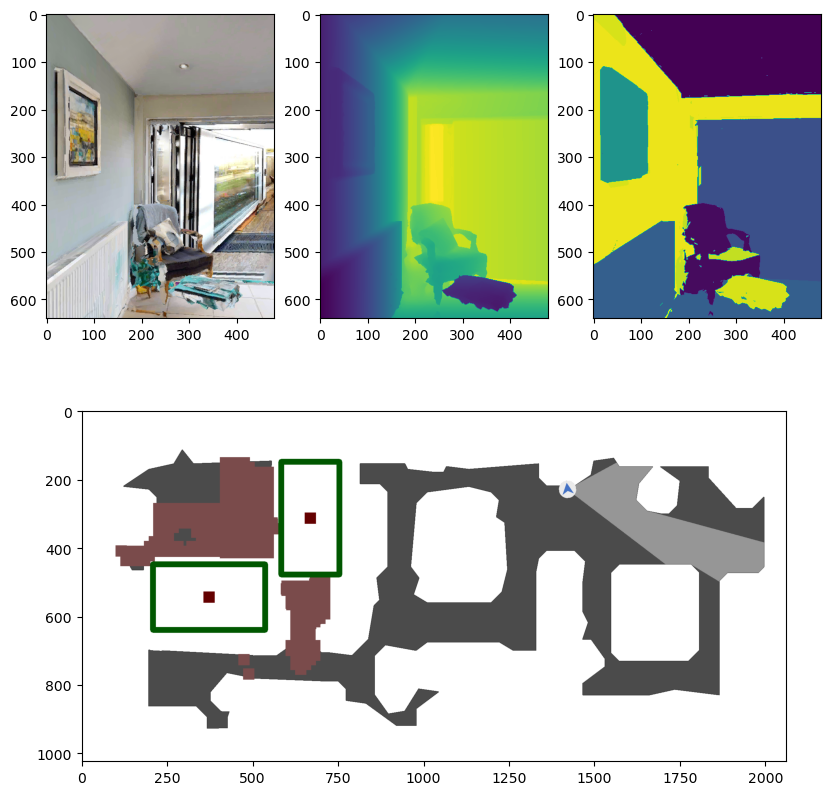

In [82]:
obs = one_env.reset(); idd = 0; done = False
obs, reward, done, info = one_env.step(action=3)
obs, reward, done, info = one_env.step(action=3)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(2,3,1)
ax1 = f.add_subplot(2,3,2)
ax2 = f.add_subplot(2,3,3)
ax3 = f.add_subplot(2,1,2)
ax.imshow(obs['rgb'])
ax1.imshow(obs['depth'][:,:,0])
ax2.imshow(one_env.sem_to_model[:,:,0])
top_down_map = draw_top_down_map(info,obs['heading'][0],obs['rgb'][0].shape[0])
ax3.imshow(top_down_map)
print(np.rad2deg(obs['compass']))

[65] [ 7  8 12 15 17 23 24 37 38 39 40]


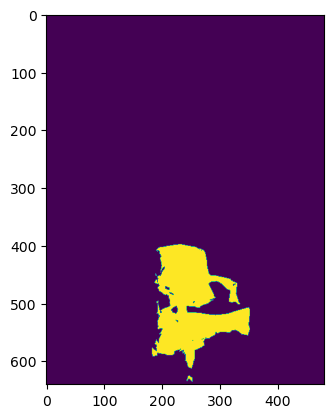

In [89]:
sem_id = 8
plt.imshow(one_env.sem_to_model[:,:,0]==sem_id)
print(one_env.objectgoal,np.unique(one_env.sem_to_model))

In [90]:
test_recurrent_hidden_states_gr = torch.zeros(1, actor_critic_gr.net.num_recurrent_layers, 512, device=device)
not_done_masks = torch.zeros(1, 1, dtype=torch.bool, device=device)
prev_actions = torch.zeros(1, 1, dtype=torch.long, device=device)
imgs = []; idd = 0
while not done:

    rgb_trans = p240(obs['rgb']).permute(1,2,0)*255
    depth_trans = p240(obs['depth']).permute(1,2,0)
    #sem_trans = p240(torch.tensor(obs[0]['semantic'])[:,:,0]).permute(1,2,0).int().float()
    sem_trans = p240(torch.tensor(one_env.sem_to_model[:,:,0]==sem_id).float()).permute(1,2,0)
    
    
    batch = batch_obs1([{'rgb':rgb_trans,
                        'depth':depth_trans,
                        'semantic':sem_trans}], device=device)
    
    with torch.no_grad():
        ac_dop1, action, ac_dop2, test_recurrent_hidden_states_gr = actor_critic_gr.act(
            batch,
            test_recurrent_hidden_states_gr,
            prev_actions,
            not_done_masks.bool())
        not_done_masks.fill_(1.0)
        prev_actions.copy_(action) 
        action = action.item()
        
    obs,reward,done,info = one_env.step(action); idd+=1
    
    print(idd,'\t',action)
    
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(2,3,1)
    ax1 = f.add_subplot(2,3,2)
    ax2 = f.add_subplot(2,3,3)
    ax3 = f.add_subplot(2,1,2)
    ax.imshow(obs['rgb'])
    ax1.imshow(obs['depth'][:,:,0])
    ax2.imshow(one_env.sem_to_model[:,:,0]==sem_id)
    top_down_map = draw_top_down_map(info,obs['heading'][0],obs['rgb'][0].shape[0])
    ax3.imshow(top_down_map)
    plot_img_np = get_img_from_fig(f)
    plt.close()
    
    imgs.append(plot_img_np)    
imgs = [{'plts':i} for i in imgs]    

1 	 1
2 	 1
3 	 1
4 	 2
5 	 1
6 	 0


In [91]:
from habitat_sim.utils import viz_utils as vut
vut.make_video(
            imgs,
            "plts",
            "color",
            '/' + "sim_basics_3rd",
            open_vid=True,
            fps=10,
        )

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1800, 1800) to (1808, 1808) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Encoding the video: /sim_basics_3rd.mp4 


[swscaler @ 0x55762213d580] Warning: data is not aligned! This can lead to a speed loss
